In [9]:
import numpy as np
import pandas as pd
import multiprocessing as mt
import matplotlib.pyplot as plt
%matplotlib inline

from tifffile import TiffFile
%run ../src/geo_helpers.py

## Average Stable Lights

In [2]:
%ls ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/

F101992.v4b_web.stable_lights.avg_vis.tif.npz
F152002.v4b_web.stable_lights.avg_vis.tif.npz
F182013.v4c_web.stable_lights.avg_vis.tif.npz


In [4]:
%%time
tif_paths = [
    '../data/external/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101992.v4b_web.stable_lights.avg_vis.tif',
#     '../data/external/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F141998.v4b_web.stable_lights.avg_vis.tif',
#     '../data/external/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F142000.v4b_web.stable_lights.avg_vis.tif',
#     '../data/external/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F182013.v4c_web.stable_lights.avg_vis.tif'
]
t_years = len(tif_paths)
n = 16801
m = 43201

images = np.zeros((len(tif_paths),n,m))
                  
for i, p in enumerate(tif_paths):
    with TiffFile(p) as tif:
        images[i] = tif.asarray()

CPU times: user 1.69 s, sys: 3.98 s, total: 5.67 s
Wall time: 6.74 s


### Extracting Subimages (Convolutional Style)

In [5]:
def convolve_coordinates(image, step_size = (150,150), sub_image_shape = (300,300)):
    passes = [int(image.shape[i]/step_size[i]-sub_image_shape[i]/step_size[i]+1) for i in range(2)]
    sub_image_coordinates = np.zeros((*passes,2,2))
    for i in range(passes[0]):
        step_i = i*step_size[0]
        for j in range(passes[1]):
            step_j = j*step_size[1]
            sub_image_coordinates[i,j] = [
                [step_i,step_i+sub_image_shape[0]],
                [step_j,step_j+sub_image_shape[1]]
            ]
            
    return sub_image_coordinates.reshape(passes[0]*passes[1],2,2)

In [6]:
sub_img_pxl = np.zeros((t_years, 31857, 2, 2))

for t, img in enumerate(images):
    sub_img_pxl[t] = convolve_coordinates(img)
    
sub_img_pxl.shape

(1, 31857, 2, 2)

Function using coordinates to retrieve information (faster)

In [7]:
def retrieve_sub_img(image,img_pxl):
    return image[img_pxl[0][0]:img_pxl[0][1],
                 img_pxl[1][0]:img_pxl[1][1]]

In [8]:
def get_pxl(df):
    return [
        [df['pxll'][0],df['pxlb'][0]],
        [df['pxll'][0],df['pxlr'][0]]
    ]

Construct dataframe

In [10]:
%%time
X_df = pd.DataFrame(columns=['year','i','f','t','mean_luminosity','pxlt','pxlb','pxll','pxlr'])

for t in range(t_years):
    for i, img_pxl in enumerate(sub_img_pxl[t]):
        img_pxl = img_pxl.astype(int)
        X_df = X_df.append(pd.DataFrame([[
            tif_paths[t][-49:-45],
            str(i) + ' ' + str(t),
            str(i),
            t,
            np.mean(retrieve_sub_img(images[t],img_pxl)),
            img_pxl[0,0],
            img_pxl[0,1],
            img_pxl[1,0],
            img_pxl[1,1],
        ]],
            columns=['year','i','f','t','mean_luminosity','pxlt','pxlb','pxll','pxlr'],
            index=[tif_paths[t][-52:-45]+' '+str(i)]
        ))
        
X_df = X_df.set_index(['i'])
X_df.head()

CPU times: user 8min 25s, sys: 22 s, total: 8min 47s
Wall time: 9min 11s


Only very few of the subimages contain a lot of lighting. This is good since we only want to extract areas with lots of luminosity information.

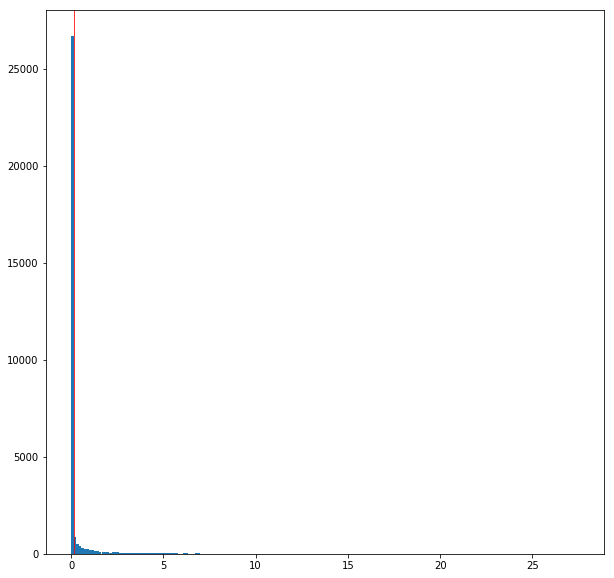

In [20]:
plt.figure(figsize=(10,10))
plt.hist(X_df['mean_luminosity'], bins=200)
plt.axvline(np.percentile(X_df['mean_luminosity'],85),color="red",lw=.8)
plt.show()

Lets find the brightest spots on earth 

In [24]:
X_df = X_df.sort_values('mean_luminosity',ascending=False)
X_df.head()

,year,f,t,mean_luminosity,pxlt,pxlb,pxll,pxlr,size
i,,,,,,,,,
7546 0,_Ser,7546,0,27.493078,3900,4200,12600,12900,300
7832 0,_Ser,7832,0,26.399822,4050,4350,12450,12750,300
5021 0,_Ser,5021,0,26.212711,2550,2850,21300,21600,300
5313 0,_Ser,5313,0,25.567478,2700,3000,22050,22350,300
7545 0,_Ser,7545,0,25.449978,3900,4200,12450,12750,300


In [26]:
X_df.rename({'pxlb':'y_off', 'pxll':'x_off', 'size': 'siz'}).to_csv('../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/sections.csv', index=False)

In [26]:
X_df.groupby('f').var().sort_values('mean_luminosity',ascending=False)['mean_luminosity'].head()

f
9997     228.155180
9998     175.845423
9710     155.101839
10285    104.363844
10284     76.545015
Name: mean_luminosity, dtype: float64

In [50]:
location_change = X_df[X_df['f'] == '10284'].sort_values('t')
location_change

,year,f,t,mean_luminosity,pxlt,pxlb,pxll,pxlr
i,,,,,,,,
10284 0,_Ser,10284,0,3.052911,5250,5550,35850,36150
10284 1,_Ser,10284,1,15.425867,5250,5550,35850,36150


In [51]:
location_change['mean_luminosity'].diff()[1:]

i
10284 1    12.372956
Name: mean_luminosity, dtype: float64

### Calculate Luminosity Change over time period
$$
\mathbb{L}_{i+1} - \mathbb{L}_{i} = \mathbb{L}_{\delta} \text{ luminosity delta}
$$

In [61]:
as_pixels(target_coords={'lat':31.23,'lng':121.47})

array([ 5253, 36177])

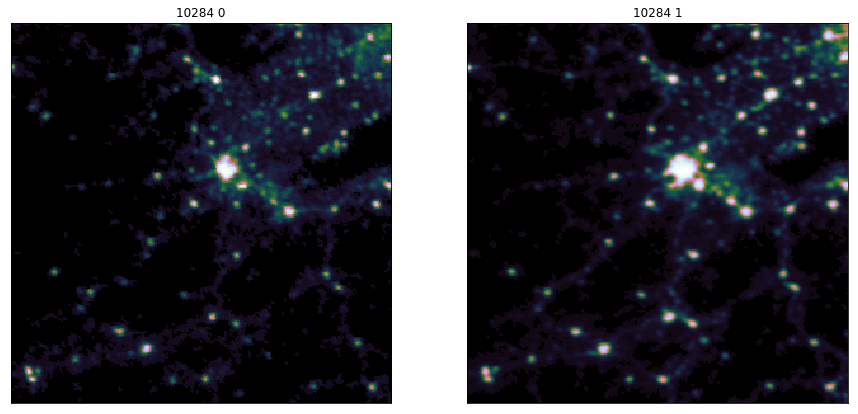

In [122]:
d = 0 
fig, ax = plt.subplots(1,2,figsize=(15,10))
for i, axi in enumerate(ax.flat):
    sub_img = retrieve_sub_img(images[i],
                     [
                         [location_change['pxlt'][i]-d,location_change['pxlb'][i]+d],
                         [location_change['pxll'][i]-d,location_change['pxlr'][i]+d]
                     ])
    axi.imshow(sub_img,cmap='cubehelix',)
    axi.set(xticks=[], yticks=[],title=location_change.index[i])

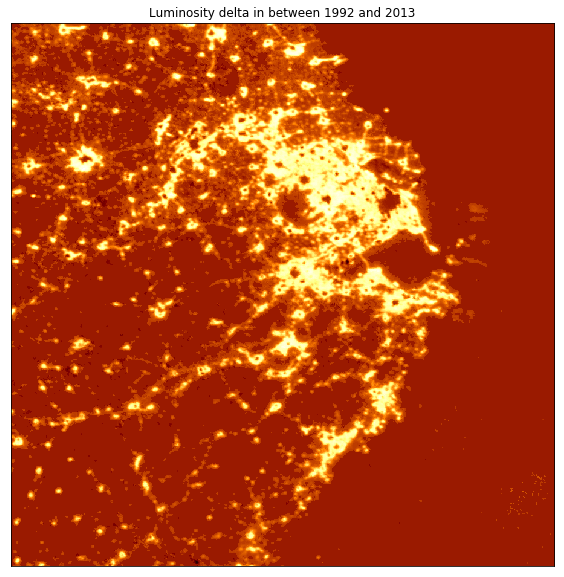

In [83]:
img_pxl = [
    [location_change['pxlt'][i]-d,location_change['pxlb'][i]+d],
    [location_change['pxll'][i]-d,location_change['pxlr'][i]+d]
]
plt.figure(figsize=(10,10))
plt.imshow(retrieve_sub_img(images[-1],img_pxl) - retrieve_sub_img(images[0],img_pxl), cmap='afmhot')
plt.xticks([])
plt.yticks([])
plt.title('Luminosity delta in between 1992 and 2013')
plt.show()

Barcelona Luminosity Change between 1992 and 2013

/Users/jpw/Development/ganter/notebooks/thesis/venv/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


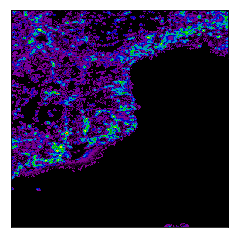

In [54]:
plt.imshow(abs(images[0][3700:4200,21700:22200] - images[-1][3700:4200,21700:22200]), cmap='spectral')
plt.xticks([])
plt.yticks([])
plt.show()

Izmir Earthquake

In [85]:
as_pixels(target_coords={'lat':40.81,'lng':29.98})

array([ 4103, 25198])

In [ ]:
retrieve_sub_img(images[i],
                     [
                     ])

In [92]:
images.shape

(4, 16801, 43201)

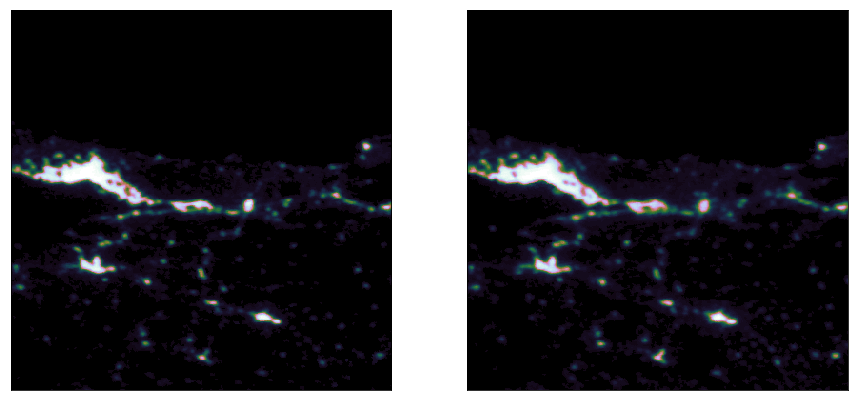

In [95]:
d = 200
fig, ax = plt.subplots(1,2,figsize=(15,10))
for i, axi in enumerate(ax.flat):
    sub_img = retrieve_sub_img(images[i+1],
                     [
                         [4103-d,4103+d],
                         [25198-d,25198+d]
                     ])
    axi.imshow(sub_img,cmap='cubehelix',)
    axi.set(xticks=[], yticks=[])

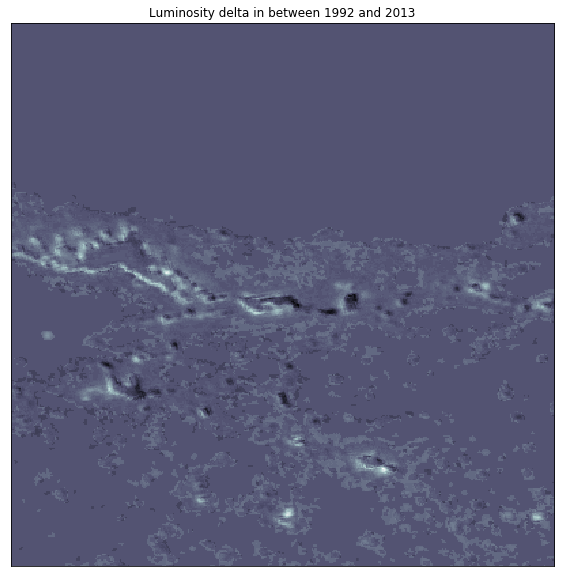

In [117]:
img_pxl = [
     [4103-d,4103+d],
     [25198-d,25198+d]
]
lightloss = (retrieve_sub_img(images[2],img_pxl) - retrieve_sub_img(images[1],img_pxl))
plt.figure(figsize=(10,10))
plt.imshow(lightloss, cmap='bone')
plt.xticks([])
plt.yticks([])
plt.title('Luminosity delta in between 1992 and 2013')
plt.show()